Train a Vision Transformer for small datasets with Latent Images from CVAE

In [1]:
# Importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

import tensorflow as tf
import keras 
from keras import layers, ops
from keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Loading Data

base_dir = '/Users/cypac/Documents/Kumudu/APProjectNew/ADMRIDataset'
categories = ['CN', 'EMCI', 'MCI', 'LMCI', 'AD']
IMAGE_SIZE = 256
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)
NUM_CLASSES = 5

# Function to load and preprocess images
def load_images_from_directory(directory, categories):
    data = []
    labels = []
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode="grayscale")
                img_array = tf.keras.preprocessing.image.img_to_array(img_array)
                data.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(data), np.array(labels)

# Loading data
x_full, y_full = load_images_from_directory(base_dir, categories)
x_full, y_full = shuffle(x_full, y_full)

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.15, random_state=42)

Error loading image /Users/cypac/Documents/Kumudu/APProjectNew/ADMRIDataset/CN/.DS_Store: cannot identify image file <_io.BytesIO object at 0x2d63a0810>
Error loading image /Users/cypac/Documents/Kumudu/APProjectNew/ADMRIDataset/EMCI/.DS_Store: cannot identify image file <_io.BytesIO object at 0x2d63a0810>
Error loading image /Users/cypac/Documents/Kumudu/APProjectNew/ADMRIDataset/MCI/.DS_Store: cannot identify image file <_io.BytesIO object at 0x2d63a0810>
Error loading image /Users/cypac/Documents/Kumudu/APProjectNew/ADMRIDataset/LMCI/.DS_Store: cannot identify image file <_io.BytesIO object at 0x2d63a0860>
Error loading image /Users/cypac/Documents/Kumudu/APProjectNew/ADMRIDataset/AD/.DS_Store: cannot identify image file <_io.BytesIO object at 0x2d63a0810>


In [3]:
# Shape of x_train, y_train, x_test, y_test

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (11900, 256, 256, 1) - y_train shape: (11900,)
x_test shape: (2100, 256, 256, 1) - y_test shape: (2100,)


In [4]:
# Preprocessing and Display functions

def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), IMAGE_SIZE, IMAGE_SIZE, 1))
    return array


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(IMAGE_SIZE, IMAGE_SIZE))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(IMAGE_SIZE, IMAGE_SIZE))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [5]:
# Normalizing and reshaping the data

x_train = preprocess(x_train)
x_test = preprocess(x_test)

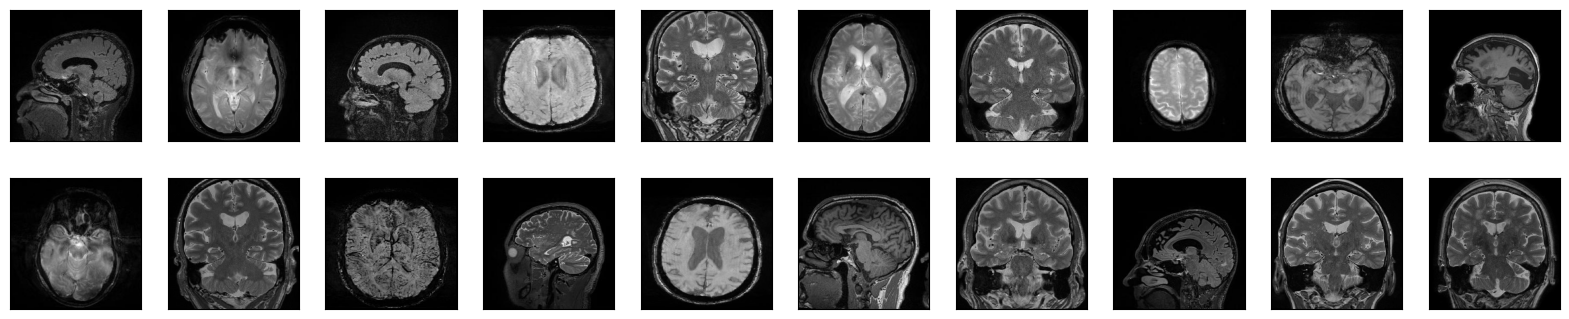

In [6]:
# Displaying the train data

display(x_train[:1000], x_test[:1000])


CVAE

In [7]:
# Creating a sampling layer for the VAE latent space

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding the image."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [8]:
# Building the CVAE

latent_dim = 64

# Encoder
encoder_inputs = keras.Input(shape=(256, 256, 1))  # Input shape 256x256x1
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)  # Downsample to 128x128x32
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 64x64x64
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 32x32x128
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 16x16x256
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 8x8x512
x = layers.Conv2D(1024, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 4x4x1024

# Variational Encoder component for retrieving latent vector z
x2 = layers.Flatten()(x)  # Flatten to (4*4*1024) = 16384 units
x2 = layers.Dense(512, activation="relu")(x2)  # Dense layer with 512 units

z_mean = layers.Dense(latent_dim, name="z_mean")(x2)  # z_mean for latent space
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x2)  # z_log_var for latent space
z = Sampling()([z_mean, z_log_var])  # Sampling layer using (z_mean, z_log_var)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


# Decoder
x = layers.Conv2DTranspose(1024, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 8x8x1024
x = layers.Conv2DTranspose(512, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 16x16x512
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 32x32x256
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 64x64x128
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 128x128x64
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 256x256x32
x = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)  # Output layer with shape 256x256x1


# Variational Decoder component For Resizing latent vector z for ViT input
latent_inputs = keras.Input(shape=(latent_dim,))  # Latent space input of size 64
x3 = layers.Dense(4 * 4 * 1024, activation="relu")(latent_inputs)  # Dense layer to match the flattened size from encoder
x3 = layers.Reshape((4, 4, 1024))(x3)                               # Reshape to 4x4x1024
x3 = layers.Conv2DTranspose(1024, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 8x8x1024
x3 = layers.Conv2DTranspose(512, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 16x16x512
x3 = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 32x32x256
x3 = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 64x64x128
x3 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 128x128x64
x3 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 256x256x32
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x3)  # Output layer (256x256x1)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    295,168 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4,      │  4,719,616 │ conv2d_4[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  8,389,120 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     32,832 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     32,832 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,742,400 (56.24 MB)

 Trainable params: 14,742,400 (56.24 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16384)          │     1,064,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 8, 8, 1024)     │     9,438,208 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 16, 16, 512)    │     4,719,104 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 32, 32, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 64, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 256, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 256, 256, 1)    │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,789,761 (64.05 MB)

 Trainable params: 16,789,761 (64.05 MB)

 Non-trainable params: 0 (0.00 B)

Getting Latent Vectors from the Autoencoder

In [9]:
# Defining the CVAE with a custom train_step

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [10]:
# Building and compiling the CVAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [11]:
# Training the CVAE
vae.fit(x_train, epochs=100, batch_size=128)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 728s 8s/step - kl_loss: 2.2497 - loss: 33850.7930 - reconstruction_loss: 33848.5469
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 721s 8s/step - kl_loss: 47.7731 - loss: 25699.5996 - reconstruction_loss: 25651.8262
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 723s 8s/step - kl_loss: 73.4401 - loss: 24991.4727 - reconstruction_loss: 24918.0352
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 722s 8s/step - kl_loss: 80.3952 - loss: 24763.0273 - reconstruction_loss: 24682.6348
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 722s 8s/step - kl_loss: 84.4797 - loss: 24618.9238 - reconstruction_loss: 24534.4434
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 724s 8s/step - kl_loss: 88.6177 - loss: 24480.6191 - reconstruction_loss: 24392.0039
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 723s 8s/step - kl_loss: 91.9429 - loss: 24373.0176 - reconstruction_loss: 24281.0742
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 723s 8s/step - kl_loss: 94.6547 - loss: 24277.4355 - reconstruction_loss: 24182.7832
Epoch 9/1

In [12]:
# Using VAE Encoder, get the latent representations (z) for the x_train dataset
z_mean, z_log_var, z = vae.encoder.predict(x_train, verbose=0)

# Using VAE Decoder, reconstruct the latent vectors (z) to match the image shape
latent_x_train = vae.decoder.predict(z, verbose=0)

In [13]:
z.shape

(11900, 64)

In [14]:
latent_x_train.shape

(11900, 256, 256, 1)

In [15]:
# Evaluating the model on the test set
vae_predictions = vae.decoder.predict(vae.encoder.predict(x_test)[2], verbose=0)


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step


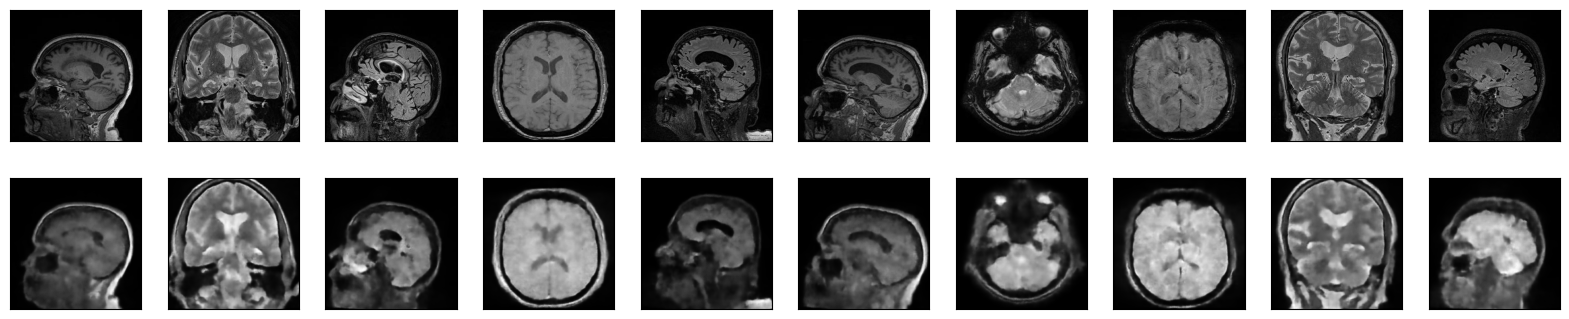

In [16]:
display(x_test, vae_predictions)

VIT

In [17]:
# Configuring Hyperparameters

INPUT_SHAPE = (256, 256, 1)

# Augmentation
IMAGE_SIZE = 256
PATCH_SIZE = 16 
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# Optimizer
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# Training
EPOCHS = 400
BATCH_SIZE = 256
BUFFER_SIZE = 512

# Architecture
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [18]:
# Data augmentation

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(latent_x_train)

ViT

In [19]:
# Implementing Shifted Patch Tokenization

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patch embed the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


ORIGINAL


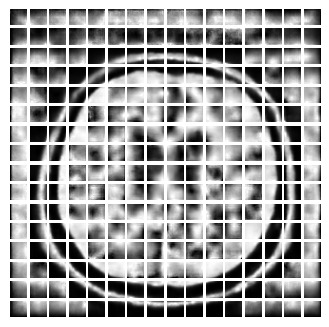

LEFT-UP


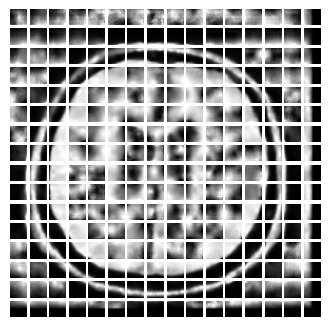

LEFT-DOWN


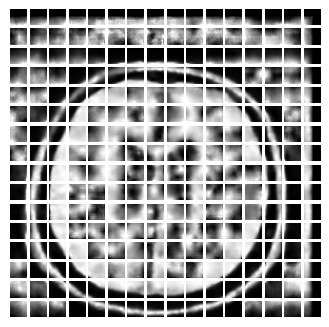

RIGHT-UP


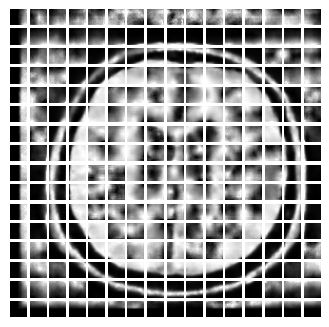

RIGHT-DOWN


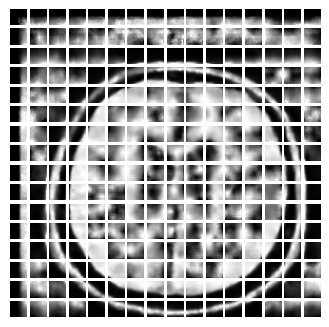

In [20]:
# Visualizing the patches

# Geting a random image and resizing it
image = latent_x_train[np.random.choice(range(latent_x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# This takes an image and divides into patches as in the original ViT paper
# (token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
# (token, patch) = (token[0], patch[0])
# n = patch.shape[0]
# count = 1
# plt.figure(figsize=(4, 4))
# for row in range(n):
#     for col in range(n):
#         plt.subplot(n, n, count)
#         count = count + 1
#         image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 1))  # Grayscale: 1 channel
#         plt.imshow(image)
#         plt.axis("off")
# plt.show()

# Shifted Patch Tokenization: This layer takes the image, 
# shifts it diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 1))  # Grayscale: 1 channel
            plt.imshow(image[..., index], cmap='gray')  # Plot in grayscale
            plt.axis("off")
    plt.show()


In [21]:
# Implementing the positional embedding on encoded patches

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


In [22]:
# Implementing Multi-Head Self Attention function - locally inside the Vit Transfomer Encoder

class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # The initial value is the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


In [23]:
# Implementing the MLP function - for Transformer Encoder and final classifier

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Building the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)


In [24]:
# Defining the function for the ViT classifier

def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    
    augmented = data_augmentation(inputs)       # Augmenting data
    
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)      # Creating patches
    
    encoded_patches = PatchEncoder()(tokens)        # Encoding patches with positions

    # Create multiple layers of the Transformer block
    for _ in range(TRANSFORMER_LAYERS):
        
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)   # Layer normalization 1
        
        # Creating a multi-head attention layer
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Creating a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    # Adding MLP
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    
    # Dense layer for classifying outputs
    logits = layers.Dense(NUM_CLASSES)(features)
    
    # Creating the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    
    return model


In [25]:
# Creating the ViT classifier and Compiling the model

vit = create_vit_classifier(vanilla=False)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

vit.compile(
        optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

In [26]:
# Training the ViT with latent_x_train

history = vit.fit(
    x=latent_x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 341s 8s/step - accuracy: 0.2090 - loss: 5.6997 - val_accuracy: 0.2664 - val_loss: 1.5821
Epoch 2/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 333s 8s/step - accuracy: 0.2393 - loss: 1.6600 - val_accuracy: 0.2849 - val_loss: 1.5453
Epoch 3/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 336s 8s/step - accuracy: 0.2740 - loss: 1.6067 - val_accuracy: 0.3193 - val_loss: 1.5171
Epoch 4/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 337s 8s/step - accuracy: 0.2773 - loss: 1.5774 - val_accuracy: 0.2975 - val_loss: 1.5124
Epoch 5/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 338s 8s/step - accuracy: 0.2843 - loss: 1.5636 - val_accuracy: 0.3319 - val_loss: 1.4952
Epoch 6/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 340s 8s/step - accuracy: 0.2798 - loss: 1.5631 - val_accuracy: 0.3437 - val_loss: 1.4706
Epoch 7/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 341s 8s/step - accuracy: 0.2934 - loss: 1.5473 - val_accuracy: 0.3613 - val_loss: 1.4491
Epoch 8/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 340s 8s/step - accuracy: 0.3043 - loss: 1.5280 - val_accuracy: 0.

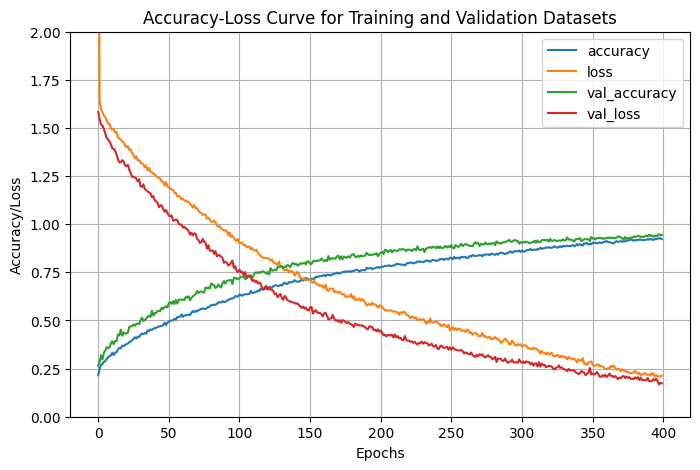

In [27]:
# Accuracy/Loss Curve
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.title('Accuracy-Loss Curve for Training and Validation Datasets')
plt.show()

In [28]:
# Evaluating the model on the test set

# Accuracy and loss for the test dataset
test_loss, test_acc = vit.evaluate(x_test, y_test)

print('\nAccuracy for Test Dataset: %.4f' % test_acc)
print('\nLoss for Test Dataset: %.4f' % test_loss)

66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 439ms/step - accuracy: 0.8213 - loss: 0.5186

Accuracy for Test Dataset: 0.8219

Loss for Test Dataset: 0.5056


In [29]:
# Getting predictions for test data (getting the highest probability class)

y_pred_probs = vit.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=-1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 441ms/step



Classification Report: 
               precision    recall  f1-score   support

          CN       0.83      0.89      0.86       441
        EMCI       0.77      0.85      0.81       405
         MCI       0.86      0.77      0.81       409
        LMCI       0.81      0.83      0.82       410
          AD       0.86      0.77      0.81       435

    accuracy                           0.82      2100
   macro avg       0.82      0.82      0.82      2100
weighted avg       0.82      0.82      0.82      2100



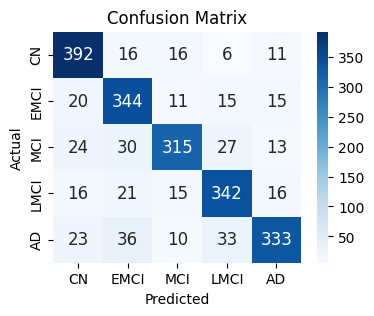

In [30]:
# Classification report 
print("\nClassification Report: \n", classification_report(y_test, y_pred, target_names=categories))

# # Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12}, xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

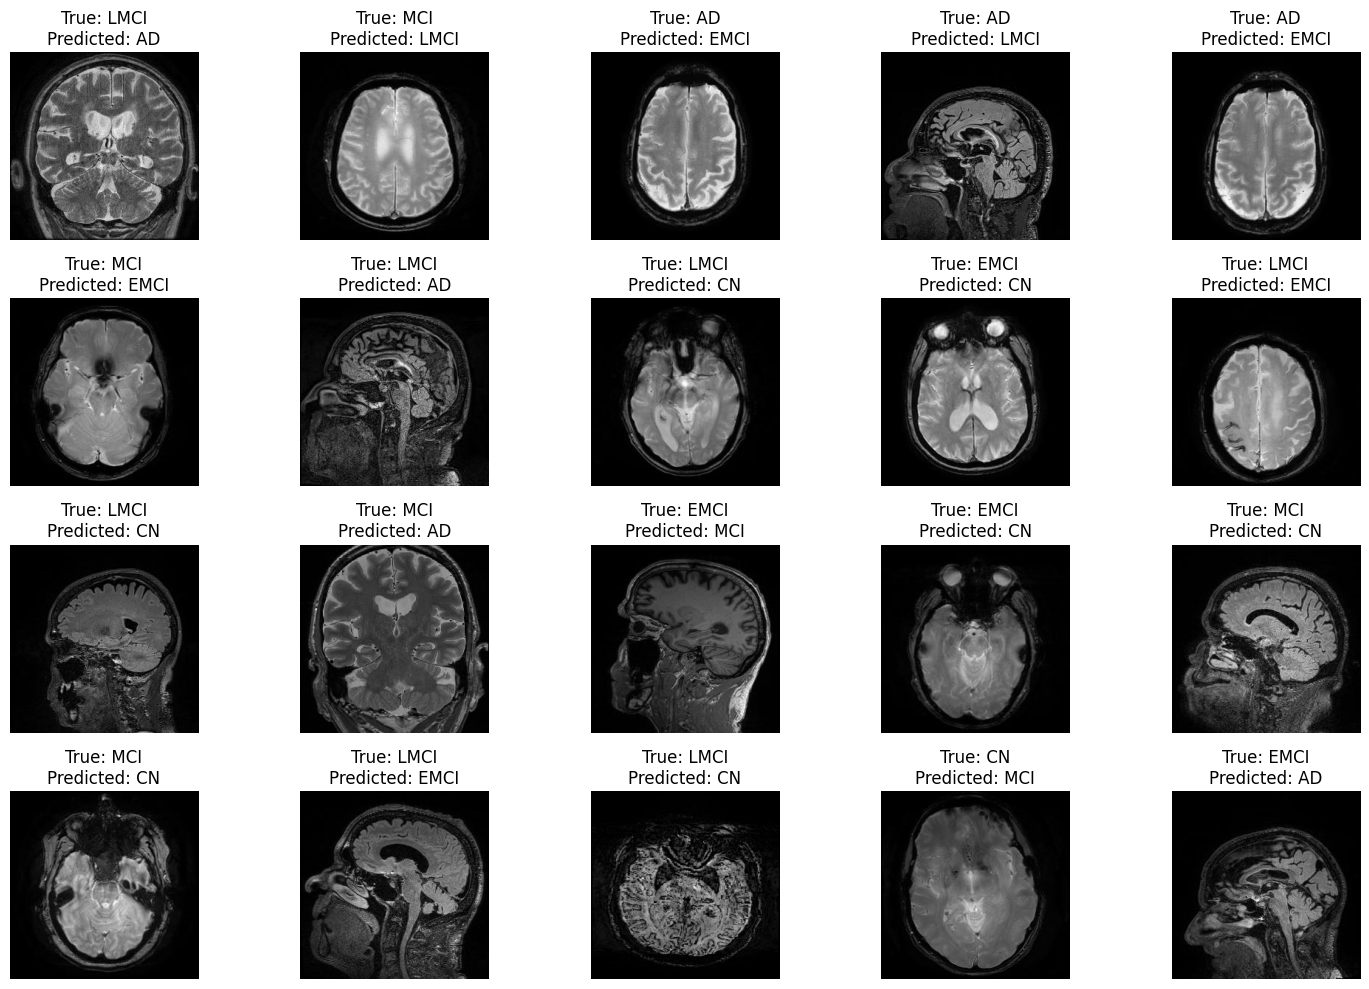

In [31]:
# Displaying the first 20 incorrect predictions

# Finding indices of incorrect predictions
incorrect_indices = np.where(y_pred != y_test)[0]

# Displaying the incorrect predictions
num_incorrect_to_display = min(20, len(incorrect_indices))

plt.figure(figsize=(15, 10))
for i, incorrect_idx in enumerate(incorrect_indices[:num_incorrect_to_display]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[incorrect_idx])
    plt.title(f"True: {categories[y_test[incorrect_idx]]}\nPredicted: {categories[y_pred[incorrect_idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
vit.save('trained_models/ViT_CVAE_latent.keras')

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# This converts y_test to a one-hot encoding
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Calculate AUC for each class
auc_values = []
for i in range(y_test_binarized.shape[1]):
    auc = roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i])
    auc_values.append(auc)

# Display per-class AUC
for class_idx, auc in enumerate(auc_values):
    print(f"AUC for class {class_idx}: {auc:.4f}")

# Optionally calculate the macro-average AUC
macro_auc = np.mean(auc_values)
print(f"Macro-average AUC: {macro_auc:.4f}")

AUC for class 0: 0.9738
AUC for class 1: 0.9528
AUC for class 2: 0.9533
AUC for class 3: 0.9632
AUC for class 4: 0.9650
Macro-average AUC: 0.9616


In [37]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC and AUC for the model
fpr_b, tpr_b, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
auc_b = auc(fpr_b, tpr_b)

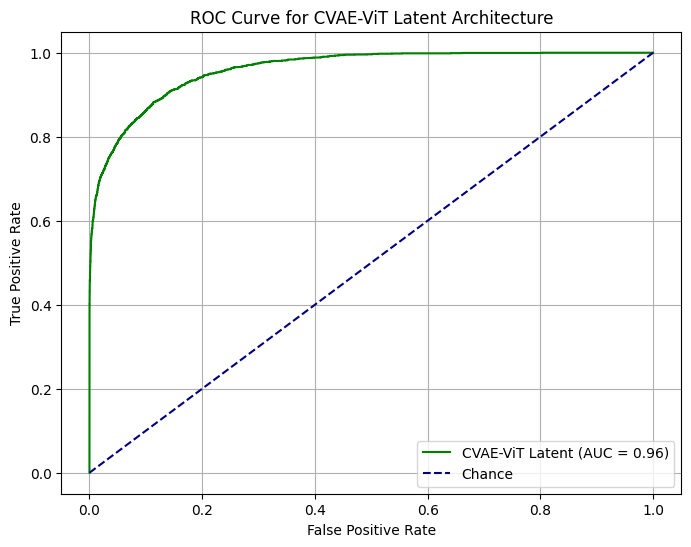

In [38]:
# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_b, tpr_b, color="green", label=f"CVAE-ViT Latent (AUC = {auc_b:.2f})")

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Chance")

# Add labels, legend, and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CVAE-ViT Latent Architecture")
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Initialize lists to store results
sensitivity = []
specificity = []

# Calculate metrics for each class
for i in range(len(categories)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivity.append(sens)
    specificity.append(spec)

# Display results
for idx, category in enumerate(categories):
    print(f"{category} - Sensitivity: {sensitivity[idx]:.2f}, Specificity: {specificity[idx]:.2f}")

CN - Sensitivity: 0.89, Specificity: 0.95
EMCI - Sensitivity: 0.85, Specificity: 0.94
MCI - Sensitivity: 0.77, Specificity: 0.97
LMCI - Sensitivity: 0.83, Specificity: 0.95
AD - Sensitivity: 0.77, Specificity: 0.97
